# Exploratory Data Analysing Using Youtube Video Data from Most Popular Data Science Channels

# 1.Introduction

## 1.1. Aims and objectives

Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How often do youtubers upload new videos? On which days in the week?
- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
    - Which questions are being asked in the comment sections in the videos

## 1.2. Steps of the project
1. Obtain video meta data via Youtube API
2. Data cleaning for analysis
3. Exploratory data analysis
4. Conclusions

## 1.3. Dataset

### Data selection

I created my own dataset using the [Google Youtube Data API version 3.0](https://developers.google.com/youtube/v3). The exact steps of data creation is presented in section *2. Data Creation* below.

### Data limitations

The dataset is a real-world dataset and suitable for the research. However, the selection of the Youtube channels to include in the research is purely based on my knowledge of the channels in relative field and might not be accurate.

### Ethics of data source

According to [Youtube API's guide](https://developers.google.com/youtube/v3/getting-started), the usage of Youtube API is free of charge given that your application send requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

In [2]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [3]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\espos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\espos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2.Data creation with Youtube API

I first created a project on Google Developers Console, then requested an authorization credential (API key). Afterwards, I enabled Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each of the channels that I would like to include in my research scope (using their URLs). Then I used the functions created by Thu VU (I have to make some debugging) for getting the channel statistics via the API.

In [4]:
api_key = ''  # DELETED FOR PRIVACY

channel_ids = [
               'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse 
               'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
               'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
               'UC2UXDak6o7rBm23k3Vv5dww', # Tina Huang
               'UCvZnwzmc3m1Eush-Or8Z6DA', # Shashank Kalanithi
               'UCJQJAI7IjbLcpsjWdSzYz0Q', # Thu Vu data analytics
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)


def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)   

### Get channel statistics

Using the `get_channel_stats` function defined below, now we are going to obtain the channel statistics for the channels in scope.

In [6]:
channel_data = get_channel_stats(youtube, channel_ids)

In [7]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Alex The Analyst,385000,14909399,193,UU7cs8q-gJRlGwj4A8OmCmXg
1,Tina Huang,459000,19150836,117,UU2UXDak6o7rBm23k3Vv5dww
2,Thu Vu data analytics,120000,3207712,58,UUJQJAI7IjbLcpsjWdSzYz0Q
3,Ken Jee,236000,7596600,258,UUiT9RITQ9PW6BhXK0y2jaeg
4,Luke Barousse,310000,14074661,117,UULLw7jmFsvfIVaUFsLs8mlQ
5,Shashank Kalanithi,120000,5367151,152,UUvZnwzmc3m1Eush-Or8Z6DA


In [8]:
channel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  6 non-null      object
 1   subscribers  6 non-null      object
 2   views        6 non-null      object
 3   totalVideos  6 non-null      object
 4   playlistId   6 non-null      object
dtypes: object(5)
memory usage: 368.0+ bytes


In [9]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [10]:
channel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  6 non-null      object
 1   subscribers  6 non-null      int64 
 2   views        6 non-null      int64 
 3   totalVideos  6 non-null      int64 
 4   playlistId   6 non-null      object
dtypes: int64(3), object(2)
memory usage: 368.0+ bytes


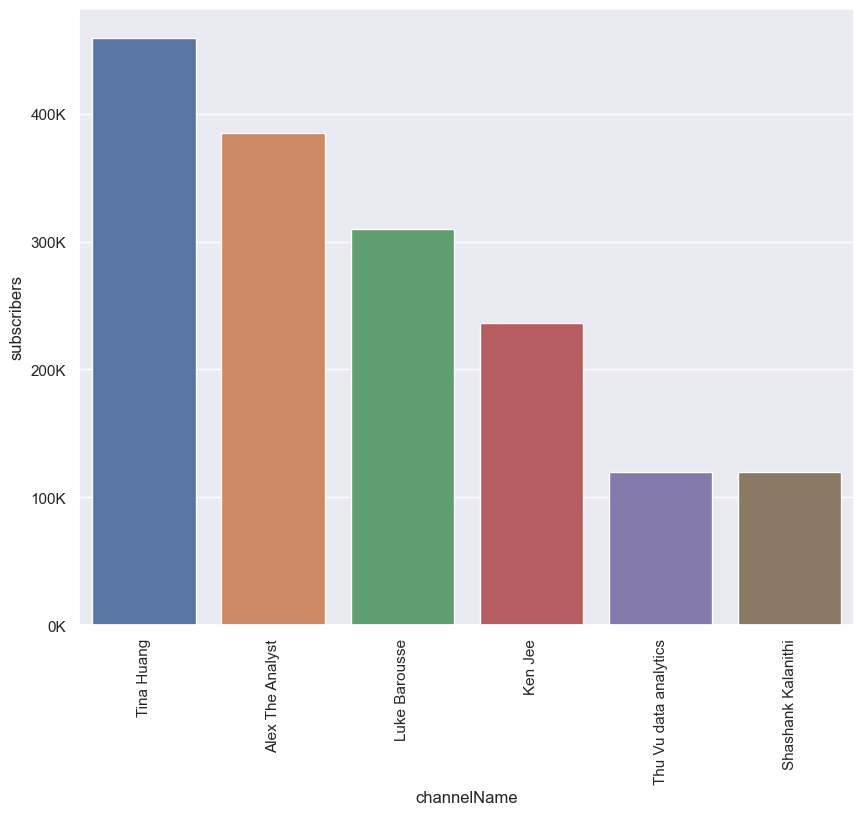

In [11]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

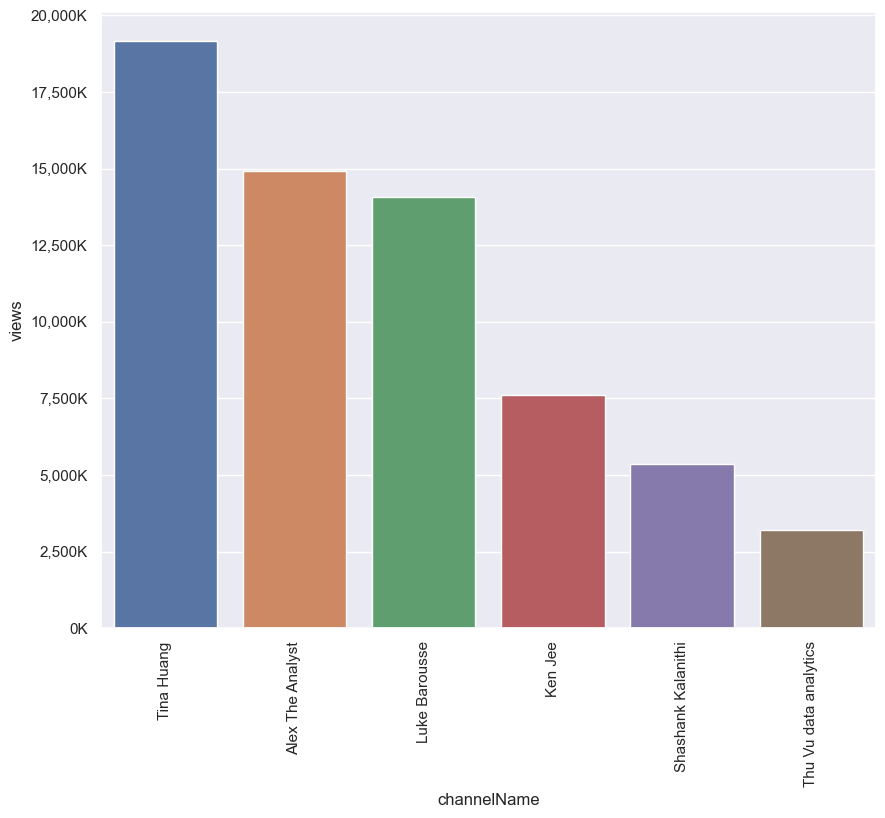

In [12]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

### Get video statistics for all the channels

In [13]:
video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = pd.concat([video_df, video_data])
    comments_df = pd.concat([comments_df, comments_data])

Getting video information from channel: Alex The Analyst
Getting video information from channel: Tina Huang
Getting video information from channel: Thu Vu data analytics
Getting video information from channel: Ken Jee
Getting video information from channel: Luke Barousse
Getting video information from channel: Shashank Kalanithi
Could not get comments for video hTujPMtft44


In [14]:
comments_df

,video_id,comments
0,C75TROiiEa0,[👋 Alex is your data analyst bootcamp Playlist...
1,rGx1QNdYzvs,[Hi Alex how can we access to those videos in ...
2,CUBfrdDwznQ,[Hi Alex I really want to break into a tech fi...
3,L-QnW_BZT3c,"[Hi, I am from Silver Spring, MD, USA. Thanks!..."
4,S76iS03nGis,[Except python second course all are available...
...,...,...
147,25Vko7udQ-g,[9:30 to read files in project directory peopl...
148,XLBFvmaxe9Y,[I wanna use this api to find distance on pyth...
149,sZDgJKI8DAM,[Hey guys this comment will have any updates I...
150,pKvWD0f18Pc,[Want to become a Data Analyst like me? Check ...


In [15]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,C75TROiiEa0,Alex The Analyst,ChatGPT for Data Analysts | Best Use Cases + A...,ChatGPT has a lot of use cases for Data Analys...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-02-14T12:30:08Z,22767,1059,None,188,PT31M7S,hd,false
1,rGx1QNdYzvs,Alex The Analyst,FREE Data Analyst Bootcamp!!,Link to Data Analyst Bootcamp Playlist: https:...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-02-07T12:30:11Z,122434,9757,None,774,PT6M52S,hd,false
2,CUBfrdDwznQ,Alex The Analyst,How to Become a Data Analyst in 2023 (Complete...,Here is my step by step process on how to beco...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-01-31T12:30:06Z,114840,6199,None,328,PT13M59S,hd,false
3,L-QnW_BZT3c,Alex The Analyst,Live Portfolio Review with Alex the Analyst! ...,Today we’ll do a live portfolio review of a Ca...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-01-25T17:14:49Z,12148,470,None,21,PT1H10M17S,hd,false
4,S76iS03nGis,Alex The Analyst,DIY Data Analyst Curriculum using Udemy (Under...,Are you wanting to learn the skills to become ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-01-24T12:30:13Z,17245,795,None,96,PT12M49S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,25Vko7udQ-g,Shashank Kalanithi,Day in the Life of a Data Analyst - SurveyMonk...,This is an R version of my popular video where...,None,2021-03-29T06:00:23Z,16946,455,None,92,PT41M55S,hd,false
149,XLBFvmaxe9Y,Shashank Kalanithi,Day in the Life of a Data Analyst - Bing Maps API,In this video I walk you through a task I did ...,None,2021-03-22T03:18:05Z,18809,781,None,98,PT29M,hd,false
150,sZDgJKI8DAM,Shashank Kalanithi,Python for Data Analysts and Data Scientists,"PRACTICE SQL, AND PYTHON HERE: https://stratas...",None,2021-03-19T00:11:46Z,147608,5707,None,281,PT2H48M51S,hd,false
151,pKvWD0f18Pc,Shashank Kalanithi,Day in the Life of a Data Analyst - SurveyMonk...,NEWEST Day in the Life of a Data Analyst: http...,None,2021-02-08T04:27:24Z,2363116,51236,None,1799,PT1H17M14S,hd,false


# 3.Data cleaning

In [16]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [17]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [18]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [19]:
# Convert count columns to numeric columns
numeric_cols = ['likeCount','viewCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [20]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [21]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [22]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,C75TROiiEa0,Alex The Analyst,ChatGPT for Data Analysts | Best Use Cases + A...,ChatGPT has a lot of use cases for Data Analys...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-02-14 12:30:08+00:00,22767,1059,None,188,PT31M7S,hd,false,Tuesday,1867.0,13,46.514692,8.257566,64
1,rGx1QNdYzvs,Alex The Analyst,FREE Data Analyst Bootcamp!!,Link to Data Analyst Bootcamp Playlist: https:...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-02-07 12:30:11+00:00,122434,9757,None,774,PT6M52S,hd,false,Tuesday,412.0,11,79.691916,6.321773,28
2,CUBfrdDwznQ,Alex The Analyst,How to Become a Data Analyst in 2023 (Complete...,Here is my step by step process on how to beco...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-01-31 12:30:06+00:00,114840,6199,None,328,PT13M59S,hd,false,Tuesday,839.0,9,53.979450,2.856148,55
3,L-QnW_BZT3c,Alex The Analyst,Live Portfolio Review with Alex the Analyst! ...,Today we’ll do a live portfolio review of a Ca...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-01-25 17:14:49+00:00,12148,470,None,21,PT1H10M17S,hd,false,Wednesday,4217.0,5,38.689496,1.728680,60
4,S76iS03nGis,Alex The Analyst,DIY Data Analyst Curriculum using Udemy (Under...,Are you wanting to learn the skills to become ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-01-24 12:30:13+00:00,17245,795,None,96,PT12M49S,hd,false,Tuesday,769.0,11,46.100319,5.566831,51


# 4.Exploratory analysis

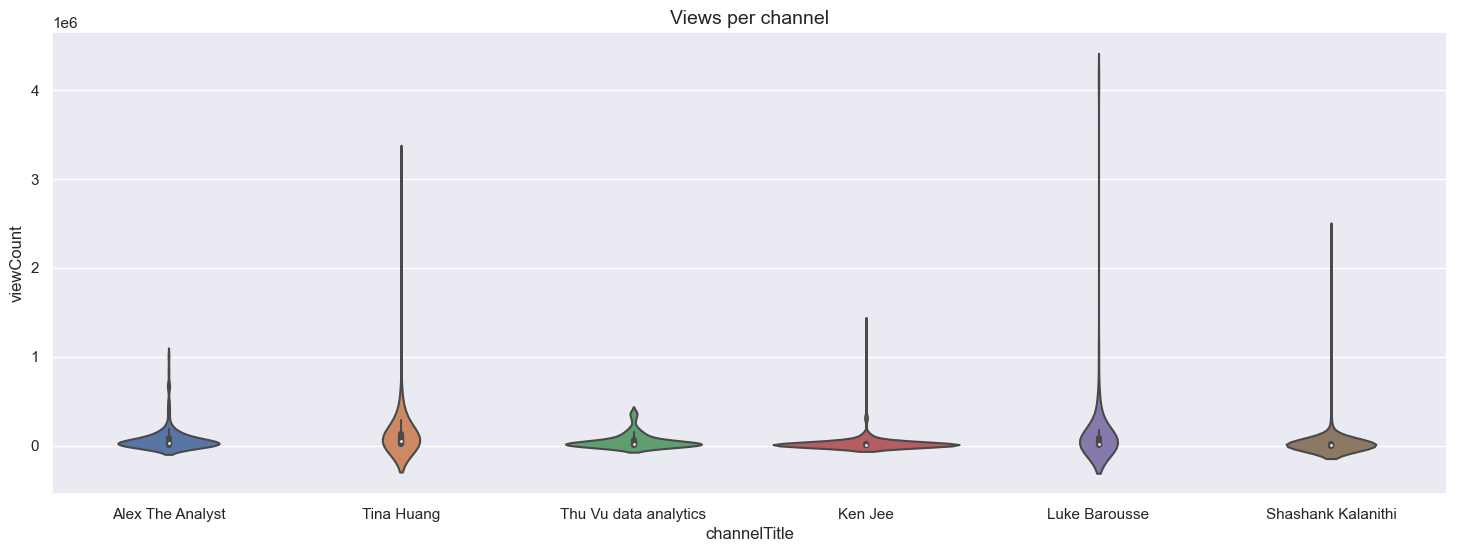

In [23]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(data=video_df, x=video_df['channelTitle'], y=video_df['viewCount'])
plt.title('Views per channel', fontsize = 14)
plt.show()


### What makes a video do well on Youtube

#### Does the number of likes and comments matter for a video to get more views?

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

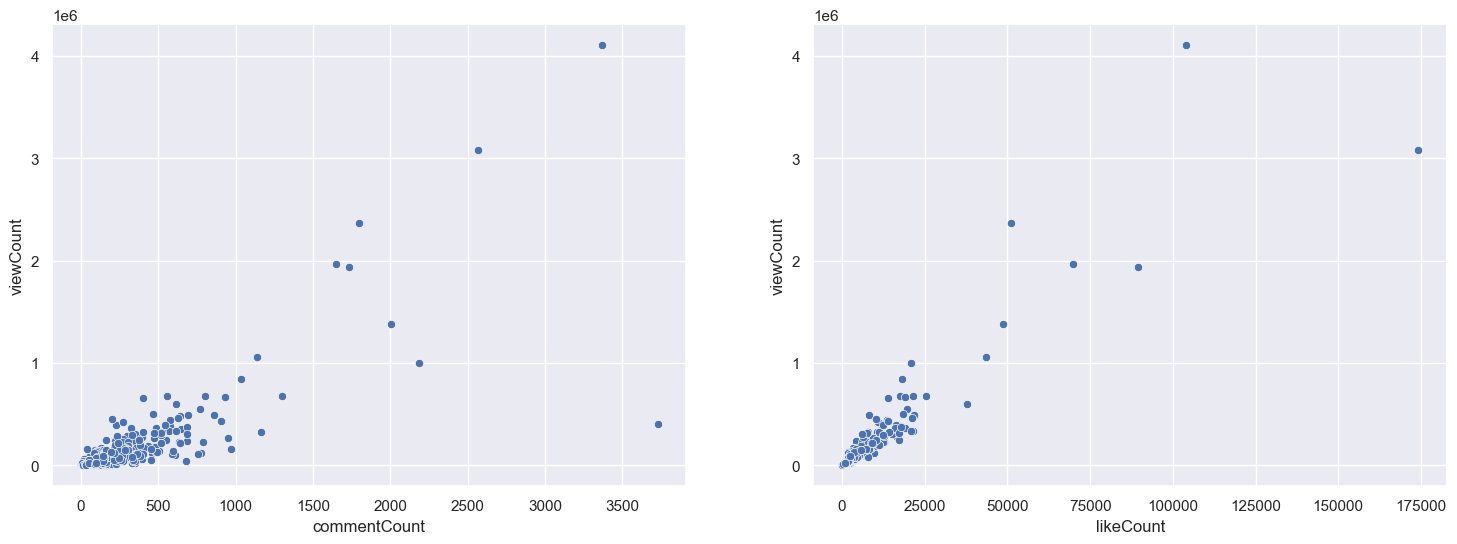

In [24]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

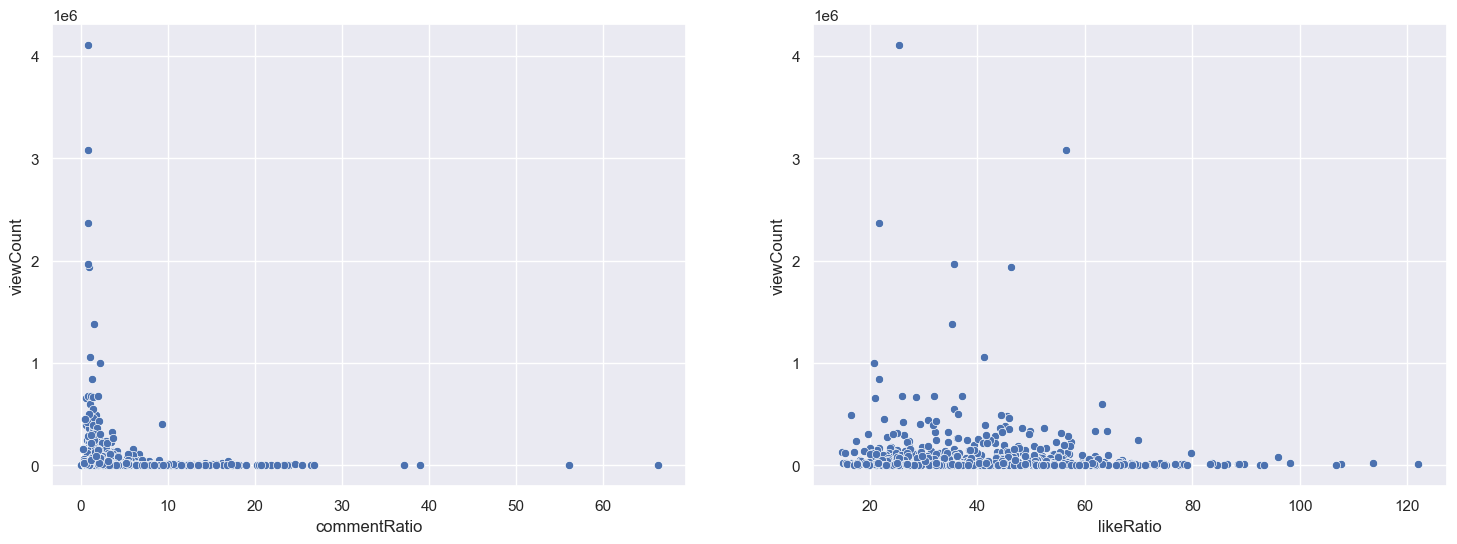

In [25]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

#### Does the video duration matter for views and interaction (likes/ comments)?

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

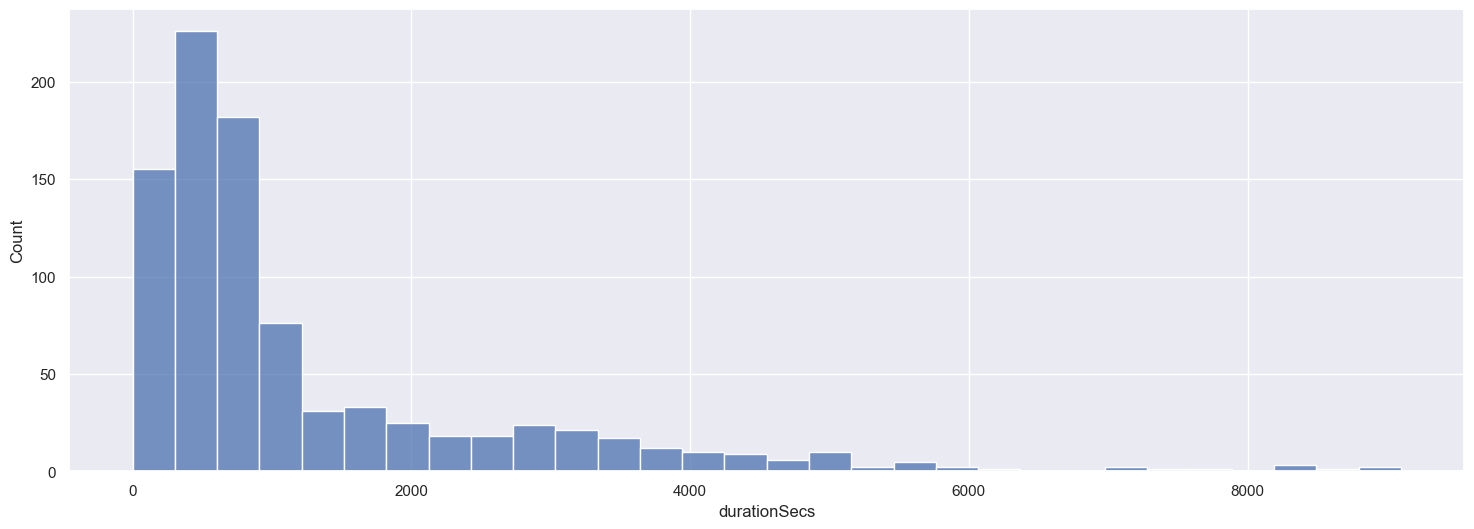

In [26]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

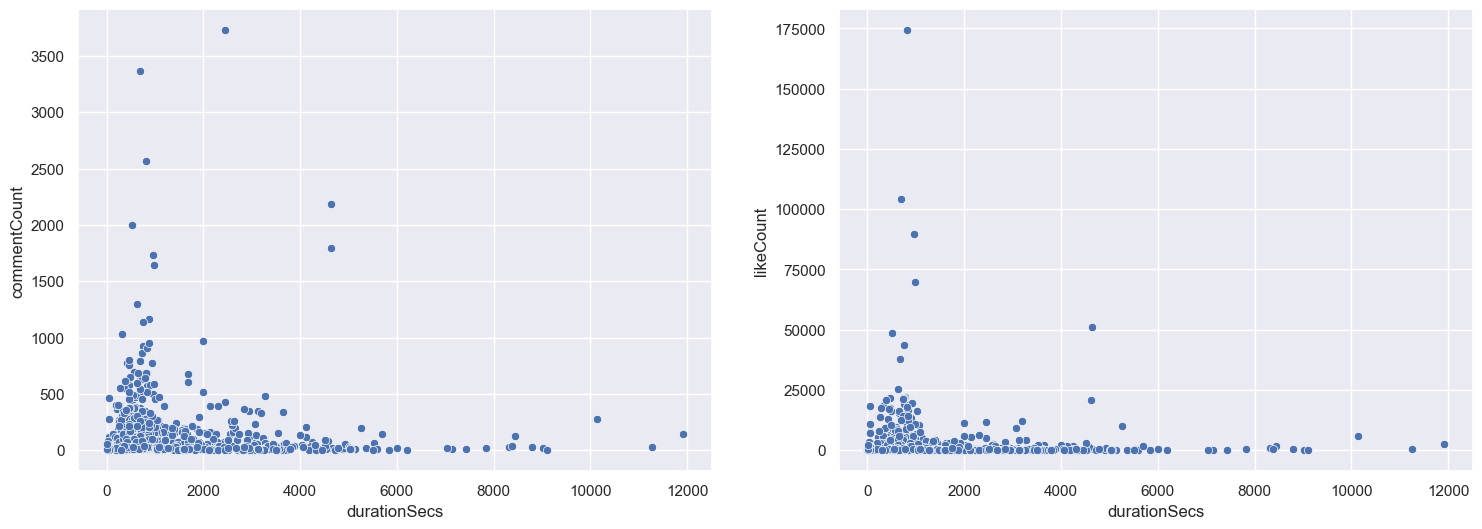

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

#### Does title length matter for views?

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

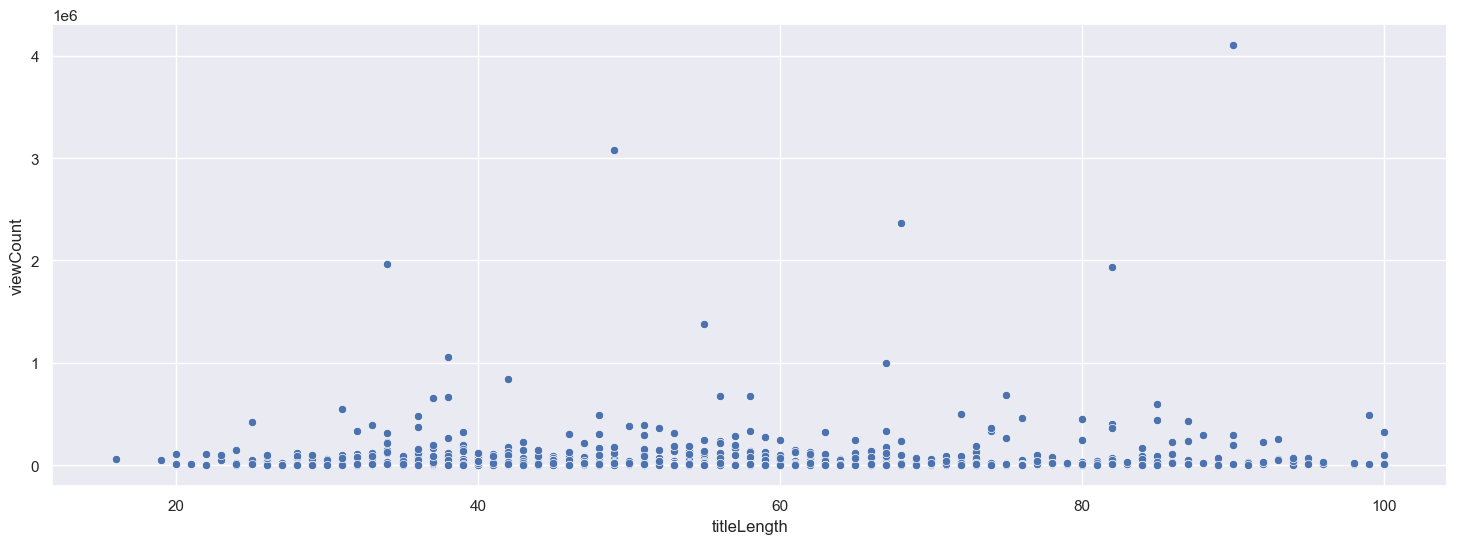

In [28]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

#### Which day in the week are most videos uploaded?

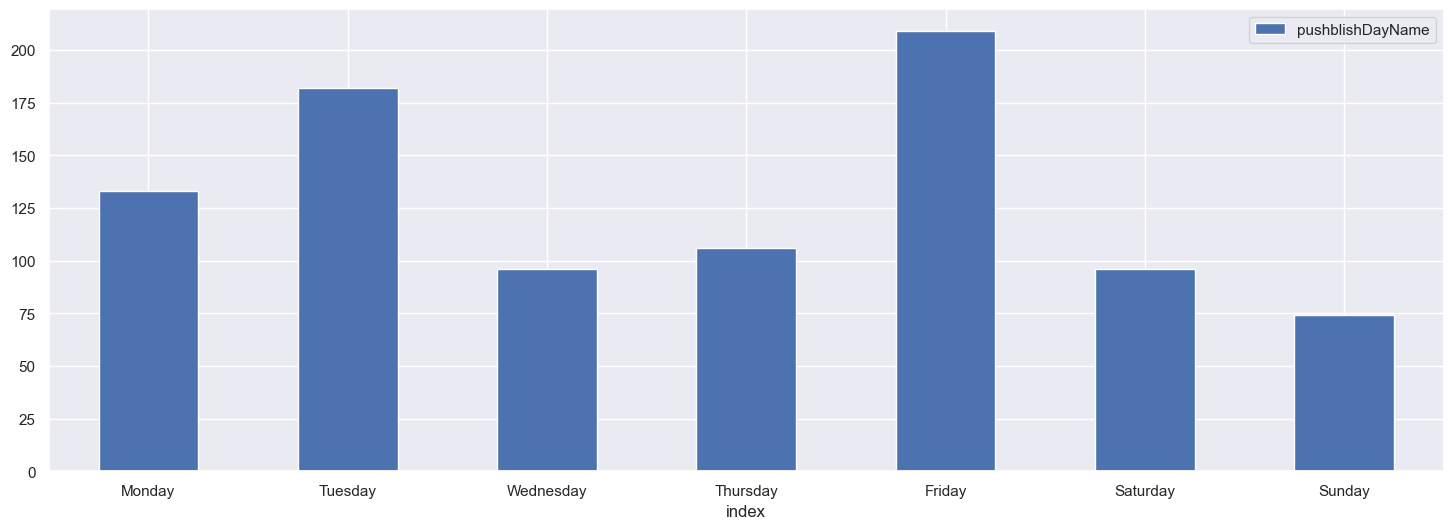

In [29]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

### NLP techniques

#### Wordcloud for words in title

In [30]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

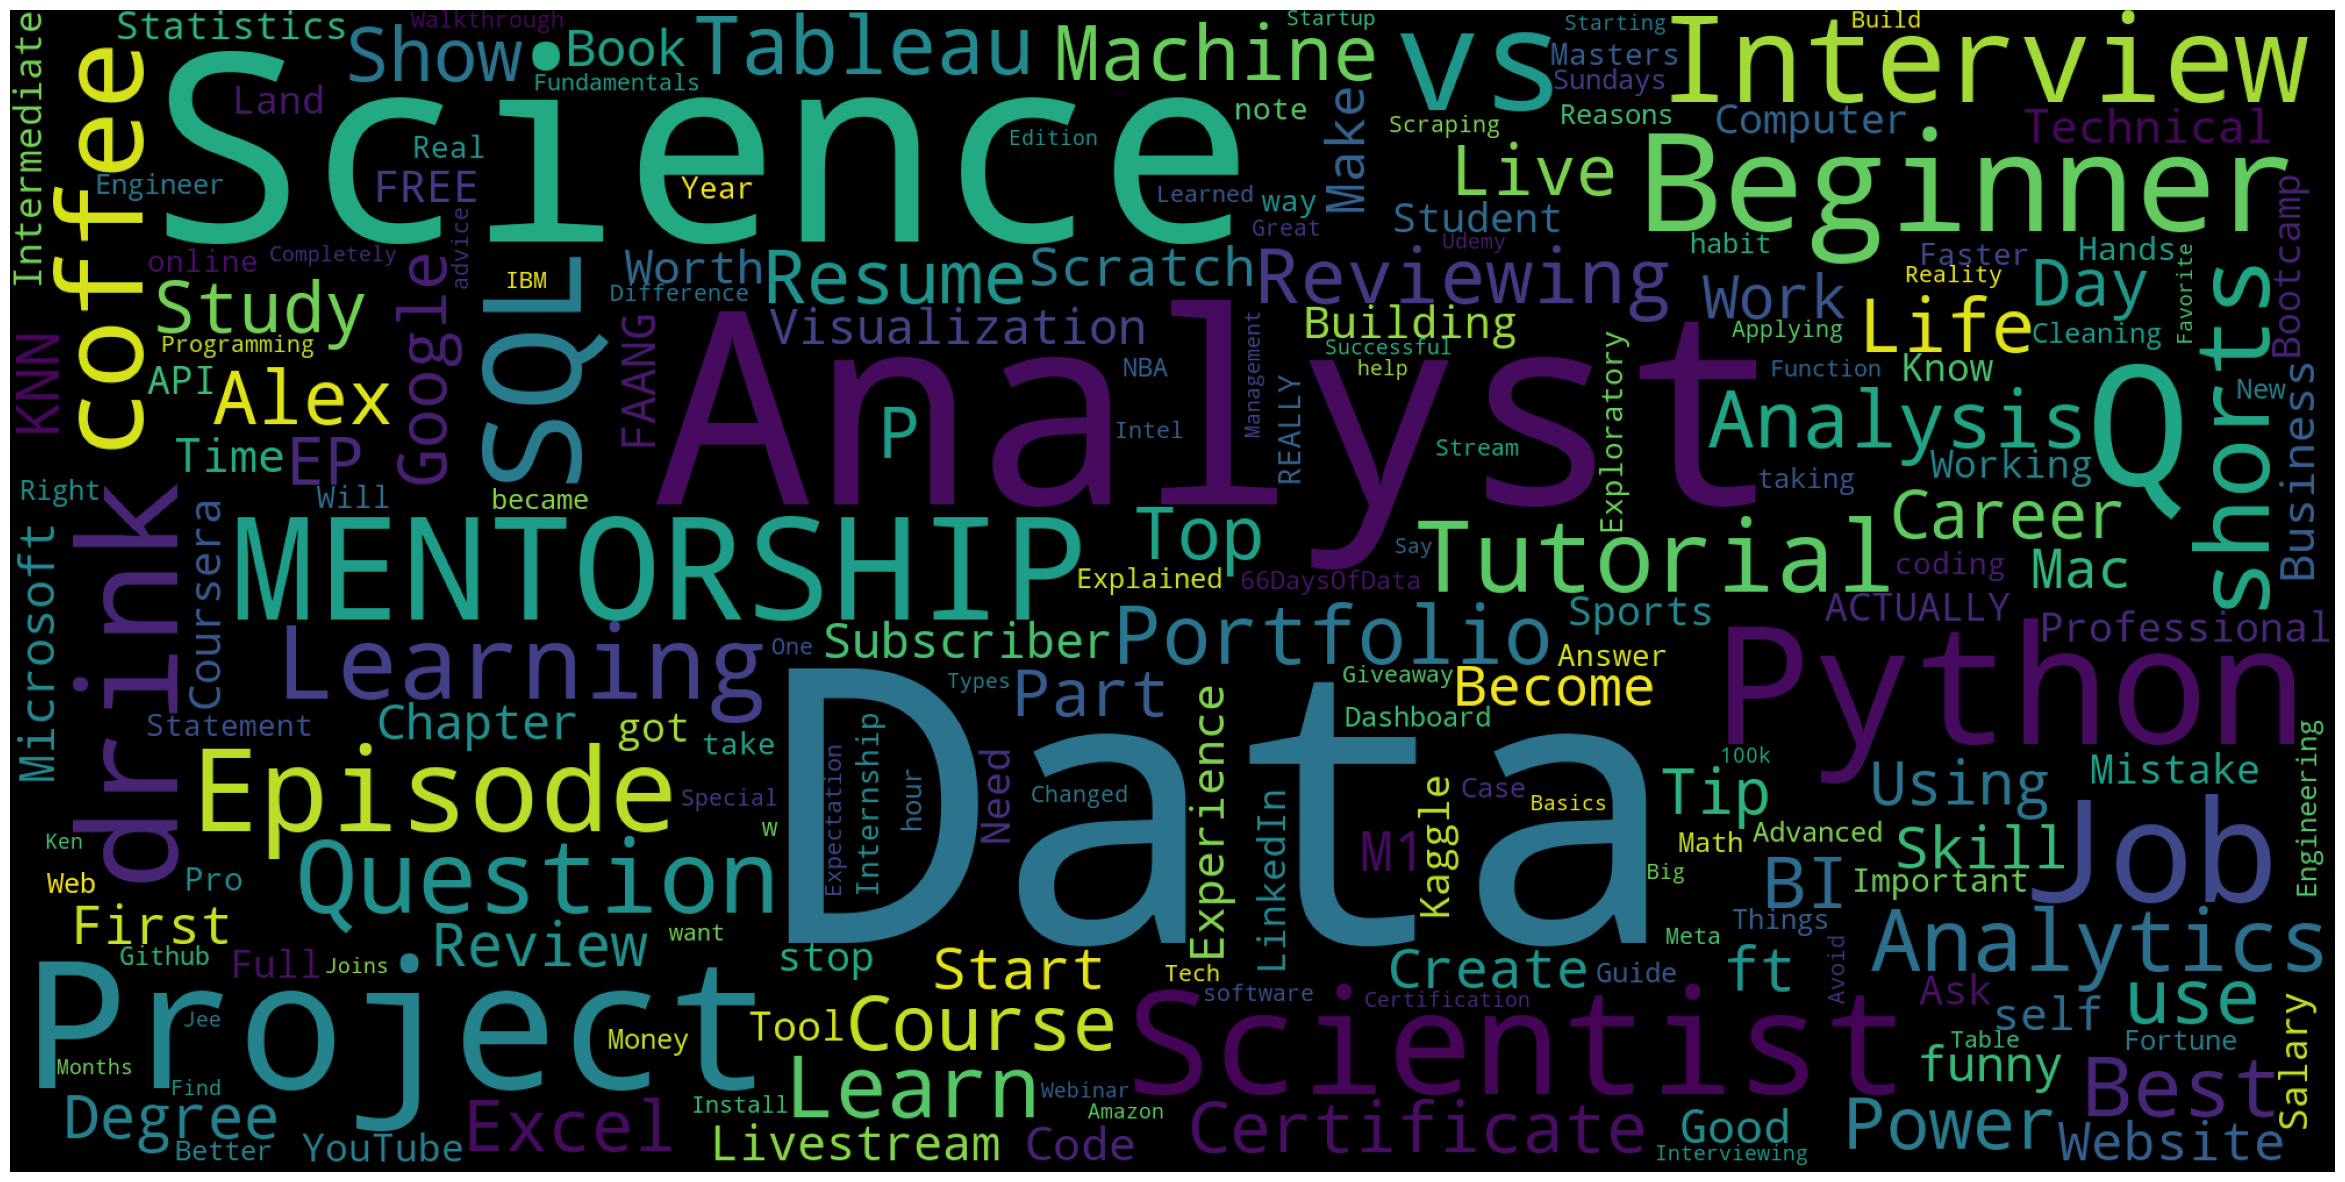

In [31]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Wordcloud for video comments

In [32]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

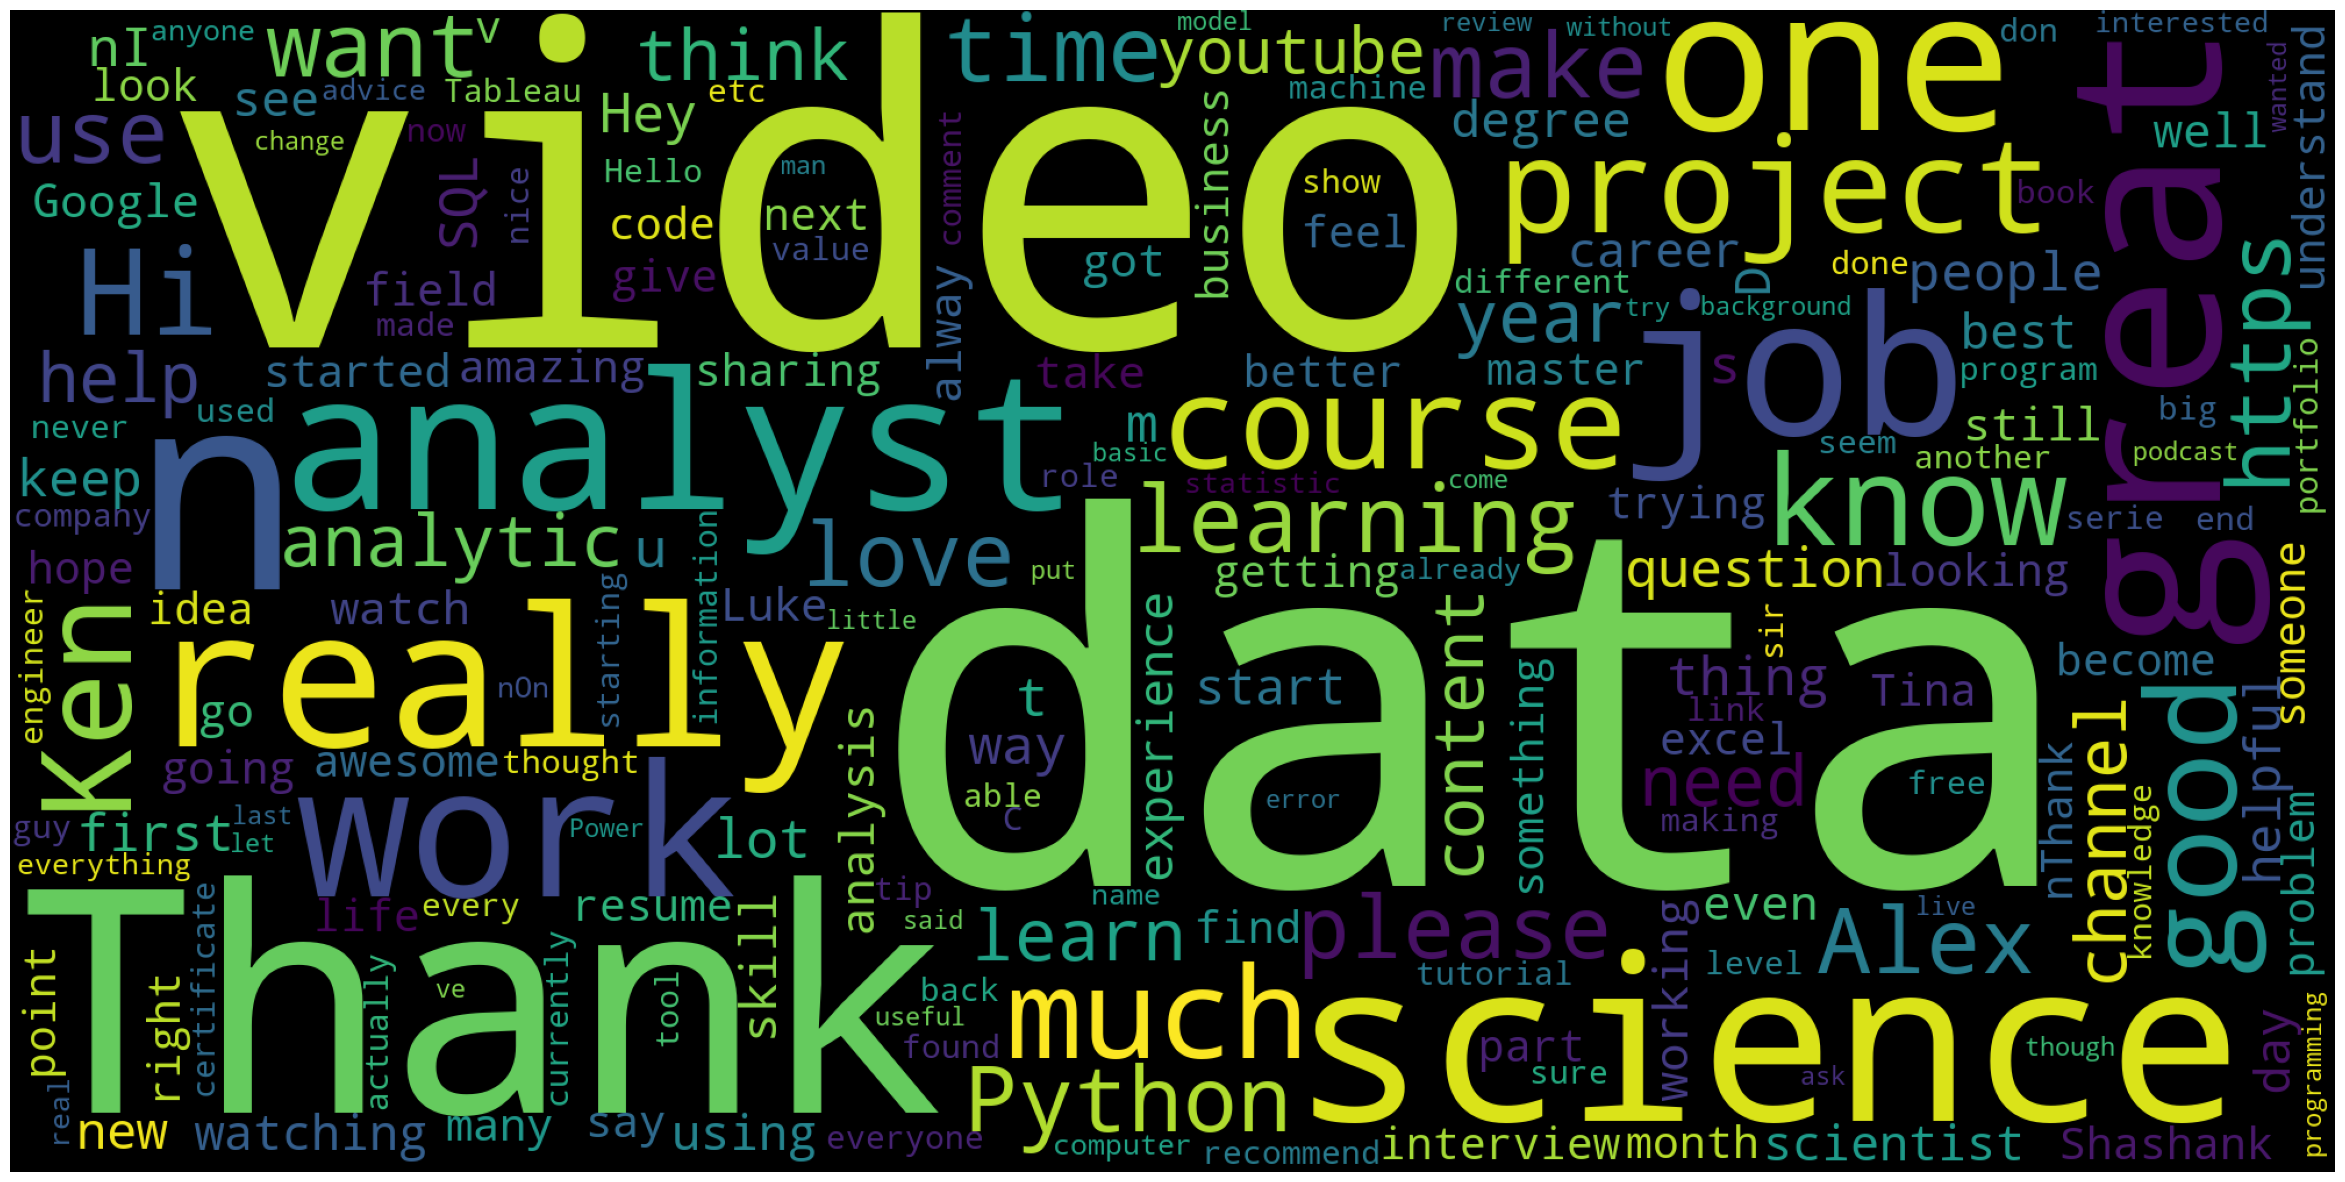

In [33]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

# 5.Conclusions

### some conclusion to add

# References/ Resources used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Video from the Youtube channel "Thu Vu data analytics". Avaiable at https://www.youtube.com/watch?v=D56_Cx36oGY

[3] Python Notebooks from the Github profile "thu-vu92". Avaiable at https://github.com/thu-vu92/youtube-api-analysis